

# Content Based Filtering
## In Music Recommendation Engines

### T00205890 25/04/2022

--------

###Streaming services use various techniques for their recommendation engines, including Content-Based Filtering. Content-Based Filtering is a means of selecting similar products based on specific features. Recommendation Systems, in particular in the area of music recommendations, use this technique to recommend songs to users based on their previous choices. Spotify uses the Content-Based Filtering algorithm, among other algorithms, to suggest songs to users, based on their previous choices.




In [ ]:
!pip install spotipy==2.10.0
!pip install textblob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import sys
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Loading the spotify.json file to extract the client_id and client_secret
credentials = json.load(open("spotify.json"))

# Authenticating the credentials in order to use the spotify
client_credentials_manager = SpotifyClientCredentials(client_id=credentials["id"], client_secret=credentials["secret"])
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
complete_feature_dataframe = pd.read_csv('SpotifyFeatures.csv')
tracks = complete_feature_dataframe[['track_name', 'track_id']].copy()

# Pre processing

Machine learning algorithms cannot work with categorical data directly.

The dataset genres are Strings, this Categorical data must be converted to numbers.


In [ ]:
# One Hot Encoding the categorical columns of dataset

genre_OHE = pd.get_dummies(complete_feature_dataframe.genre)
key_OHE = pd.get_dummies(complete_feature_dataframe.key)
dataset_genres = ['A Capella', 'Alternative', 'Anime', 'Blues', "Children's Music",  'Children’s Music', 'Classical', 
                  'Comedy', 'Country', 'Dance', 'Electronic',  'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 
                  'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World']

In [ ]:
# Droping the categorical columns and the onces that are not features of the songs
complete_feature_dataframe = complete_feature_dataframe.drop('genre',axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('artist_name', axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('track_name', axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('popularity',axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('key', axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('mode', axis = 1)
complete_feature_dataframe = complete_feature_dataframe.drop('time_signature', axis = 1)

In [ ]:
# Joining the one hot encoded columns from categorical columns i.e, genre and key
complete_feature_dataframe = complete_feature_dataframe.join(genre_OHE)
complete_feature_dataframe = complete_feature_dataframe.join(key_OHE)

# Implementation 

The getPlaylistDataFrame function takes in a URL from any publically available playlist, and using the Spotipy Python Library it converts the songs from that playlist into a usable dataframe.

In [ ]:
# Function to extract all the songs in the playlist from URL and reurtn the dataframe
def getPlaylistDataFrame(URL):  
    
    # extracting the playlist_id after we split the URL by '/' and using the 
    # string and 4th index. Afterwards in that index, extracting all alphabets before
    # '?'
    playlist_id = URL.split("/")[4].split("?")[0]
    
    # Extracting playlist dictionary from spotify by having playlist_id
    playlist_tracks_data = sp.playlist_tracks(playlist_id)
    

    # Creating lists to extract information from playlist
    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_genres = []

    # extracting the ids, titles, artists, and first artists, genres from the paylist and appending
    # the values one by one into the lists
    for track in playlist_tracks_data['items']:
        playlist_tracks_id.append(track['track']['id'])
        playlist_tracks_titles.append(track['track']['name'])
        
        artist_list = []
        for artist in track['track']['artists']:
            artist_list.append(artist['name'])
        playlist_tracks_artists.append(artist_list)
        playlist_tracks_first_artists.append(artist_list[0])
        
        artist_uri = track["track"]["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)
        artist_genres = artist_info["genres"]
        
        genre_list = []
        for genre in artist_genres:
            genre_list.append(genre)
            
        playlist_tracks_genres.append(genre_list)
        

    # extracting the audio features from spotify by using playlist_tracks_ids
    features = sp.audio_features(playlist_tracks_id)
    
    # creating features dataframe from features list
    features_df = pd.DataFrame(data=features, columns=features[0].keys())
    
    # defining the title, first_artist, all artistsm genre for feature_df by using the already created lists
    features_df['title'] = playlist_tracks_titles
    features_df['first_artist'] = playlist_tracks_first_artists
    features_df['all_artists'] = playlist_tracks_artists
    features_df['genre'] = playlist_tracks_genres
    
    
    # extracting the required columns
    features_df = features_df[['id', 'title', 'first_artist', 'all_artists',
                                'acousticness', 'danceability', 'duration_ms', 
                               'energy', 'instrumentalness', 'liveness', 
                               'loudness', 'speechiness', 'tempo', 'valence', 'key', 'genre']]
    return features_df



## URL of the playlist we would like to make a dataframe

In [ ]:
URL = "https://open.spotify.com/playlist/78HhelFFSkYy4CEXsaf4dA?si=0f7219af3d70464e"
playlist_dataframe = getPlaylistDataFrame(URL)

## Feature Columns from the dataset, creating a playlist dataframe 

In [ ]:
# These are the feature columns from the dataset from spotifyFeatures.csv
# from A Capella to Rock are genres and from A to G# are keys

feature_columns = ['A Capella', 'Alternative', 'Anime', 'Blues',
                   "Children's Music", 'Children’s Music', 'Classical', 'Comedy',
                   'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
                   'Movie', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock',
                   'Ska', 'Soul', 'Soundtrack', 'World', 'A', 'A#', 'B', 'C', 'C#', 'D',
                   'D#', 'E', 'F', 'F#', 'G', 'G#']

audio_features = ['acousticness', 'danceability', 'duration_ms',  'energy', 'instrumentalness', 'liveness', 
                  'loudness', 'speechiness', 'tempo', 'valence']

keys = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

genres = ['A Capella', 'Alternative', 'Anime', 'Blues',
          "Children's Music", 'Children’s Music', 'Classical', 'Comedy', 'Country', 'Dance', 'Electronic', 'Folk', 
          'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 
          'Soundtrack', 'World']
                               
# This function will return one hot encoded features from the playlist passed to it with categorical genre and key columns
def create_playlist_df(playlist):
    playlist_df = playlist.copy()
    # The keys are mapping to the index values. The index values are actually the pitch values ranging from 0-11
    keys = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G','G#', 'A', 'A#', 'B']
    
    # creating new columns for each genre and keys
    for column in feature_columns:
        playlist_df[column] = 0.0
        
    # one hot encoding the genre and key columns
    for index in playlist_df.index:
        genres = playlist_df.iloc[index]["genre"]
        for genre in genres:
            if genre.title() in np.char.title(dataset_genres):
                playlist_df.at[index,genre.title()] = 1
            else:
                for word in genre:
                    if word.title() in np.char.title(dataset_genres):
                        playlist_df.at[index,word.title()] = 1
                    
        key_index = playlist_df.iloc[index]["key"]
        if key_index >= 0 and key_index <= 11:
            playlist_df.at[index,keys[key_index]] = 1

    # going to drop the categorical columns and those which are not the features of the songs    
    playlist_df = playlist_df.drop('genre', axis = 1)
    playlist_df = playlist_df.drop('key', axis = 1)
    playlist_df = playlist_df.drop('title', axis = 1)
    playlist_df = playlist_df.drop('first_artist', axis = 1)
    playlist_df = playlist_df.drop('all_artists', axis = 1)
        
    return playlist_df

# created playlist features dataframe, which is essentially only the features of each track
playlist_features_df = create_playlist_df(playlist_dataframe)



# storing the playlist_features columns and columns from complete_features_df so that they can
# be used later to extract specific features
playlist_features_df_columns = playlist_features_df.columns.values
complete_feature_dataframe_columns = complete_feature_dataframe.columns.values

# Normailizating 
# Applying scaling in the orginal complete feature dataframe
scalar = MinMaxScaler()
scalar.fit(complete_feature_dataframe[complete_feature_dataframe_columns[1:]])

scaled_features = scalar.transform(complete_feature_dataframe[complete_feature_dataframe_columns[1:]])

# scaled_features returned from the transform funciton was an array so we have to create the dataframe
# from it again
scaled_features = pd.DataFrame(scaled_features, columns = complete_feature_dataframe_columns[1:])

scaled_features['track_id'] = complete_feature_dataframe['track_id']
complete_feature_dataframe = scaled_features.copy()

# going to apply the same scaling we applied on the complete_playlist dataframe on the playlist_features_df
scaled_features = scalar.transform(playlist_features_df[playlist_features_df_columns[1:]])
scaled_features = pd.DataFrame(scaled_features, columns = playlist_features_df_columns[1:])

scaled_features['id'] = playlist_features_df['id']
playlist_features_df = scaled_features.copy()

## Function to generate Recommendation Playlist from the URL

In [ ]:
# Function to generate a recommended playlist and return top five songs in it
# df consists of only tracks_id and tracks_names and will only be used to return these outputs of the top
# recommendattions
def generate_recommend_playlist(feature_df, playlist_df, df):
    
    complete_feature_set_playlist = playlist_df[playlist_features_df_columns].copy()

    
    # The songs which are not in the current playlist will be saved to complete_feature_set_nonplaylist which will be used
    # recommend songs
    complete_feature_set_nonplaylist = feature_df[~feature_df['track_id'].isin(playlist_df['id'].values)]
    
    # going to save the df which does not have any songs from the playlist so that those songs from df which have highest
    # cosine similarity can be returned
    df = df[~df['track_id'].isin(playlist_df['id'].values)]
    
    # Dropping id from complete_feature_set_playlist because we don't need it to recommend songs or it's not part of the
    # features
    complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "id")
    
    # extracting the average of all the values in each column and saving it to features
    # This sum will be used later in cosine similarity function to find similarity between recommended songs and the current
    # playlist
    
    features = complete_feature_set_playlist_final.sum(axis = 0)
    for key in keys:
        if features[key] != 0:
            features[key] = 1
            
    for genre in genres:
        if features[genre] != 0:
            features[genre] = 1
    
    
    # saving a copy of complete_feature_set_nonplaylist to non_playlist_features 
    nonplaylist_features = complete_feature_set_nonplaylist[complete_feature_dataframe_columns].copy()
    
  
    # Creating an array from features dataset
    features_array = features.values
    
    # reshaping features array to a two dimensional array 
    # the new shape will be (1, number of values in features_array)
    # In other words a vector of features array will be saved in an array resulting in a two dimensional array
    features_two_dimensional_array = features_array.reshape(1,-1)
    
    
    # Not going to use id as a feature for recommendation
    non_playlist_features_without_id = nonplaylist_features.drop('track_id', axis = 1)
    
    # going to save the ids in a single array
    non_playlist_features_without_id_array = non_playlist_features_without_id.values
    
    # Using cosine similarity to calculate between all the songs outside of current playlist and the features from the current
    # playlist. This will return a two dimensional array haveing a single vector of cosine values
    
    two_dimensional_array = cosine_similarity(non_playlist_features_without_id_array, features_two_dimensional_array)
    
    # Going to vectorize the two dimensional array so that it can be stored in a specific column afterwards
    single_array = two_dimensional_array[:, 0]
    
    # storing the cosine values in a separate column. The values correspond to the respective tracks to show how much similarity
    # they have. The larger the value the greater is the similarity and hence good for recommendation
    df['sim'] = single_array
    
    # Sorting the dataframe based on the cosine similarity calculated.. Those songs which have highest similarity will be
    # in the top and the top 5 will be returned

    # HEAD CHANGED TO NUMBER OF RECOMMENDATIONS DESIRED
    non_playlist_df_top_5 = df.sort_values('sim',ascending = False).head(20)
    
    return non_playlist_df_top_5

In [ ]:
result = generate_recommend_playlist(complete_feature_dataframe, playlist_features_df, tracks)
result = result.drop('sim', axis = 1)
result = result.drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
recommendation_features = complete_feature_dataframe.iloc[result.index]

In [ ]:
# Printing the  top five songs 
recommended_songs = 16

for i in range(recommended_songs):
    print(str(result.iloc[i,0]) + ' - ' + "https://open.spotify.com/track/"+ str(result.iloc[i,1]).split("/")[-1])

PROUD - https://open.spotify.com/track/365wwIjijQdlRJEjUWTidq
The Mood - https://open.spotify.com/track/4yCuBvbBvoJ9eVE7QB2Rkg
FUCK 12 (feat. Offset) - https://open.spotify.com/track/2jBQmxZpQxF8jJfEdjJ9Qv
Se Olvidó - https://open.spotify.com/track/2lQkPuLLQ3gs2tXj7VAYDH
Loner - https://open.spotify.com/track/6m6R6O2BOZDCNymhJ45spI
The Race - https://open.spotify.com/track/3F3N97ZRJJf42YPpwy4iJZ
Nephelococcygia (Cloud-Cuckooland) - https://open.spotify.com/track/3S16UM2l4UI2pkyaGb0Vsm
Ya Me Enteré - https://open.spotify.com/track/4ggabbjjuHrG06SsYnqvEs
Subete - https://open.spotify.com/track/6CWMm2mJOrKyDH4W1X5d06
Mahishasura Mardini Sthothram Traditional Tune - https://open.spotify.com/track/4dVhZ2EXWZwXrVAbLwRWM7
Can't Leave Drank Alone - https://open.spotify.com/track/1uAmSjg1c8JLzkWlZS2yWQ
Así Quería Mirarte - https://open.spotify.com/track/658OMPqTG1ASncKCnhsGOl
Bembele - https://open.spotify.com/track/15EizJru9cFp78KS80meBx
one of us - https://open.spotify.com/track/0Klm9VlhZkNIF

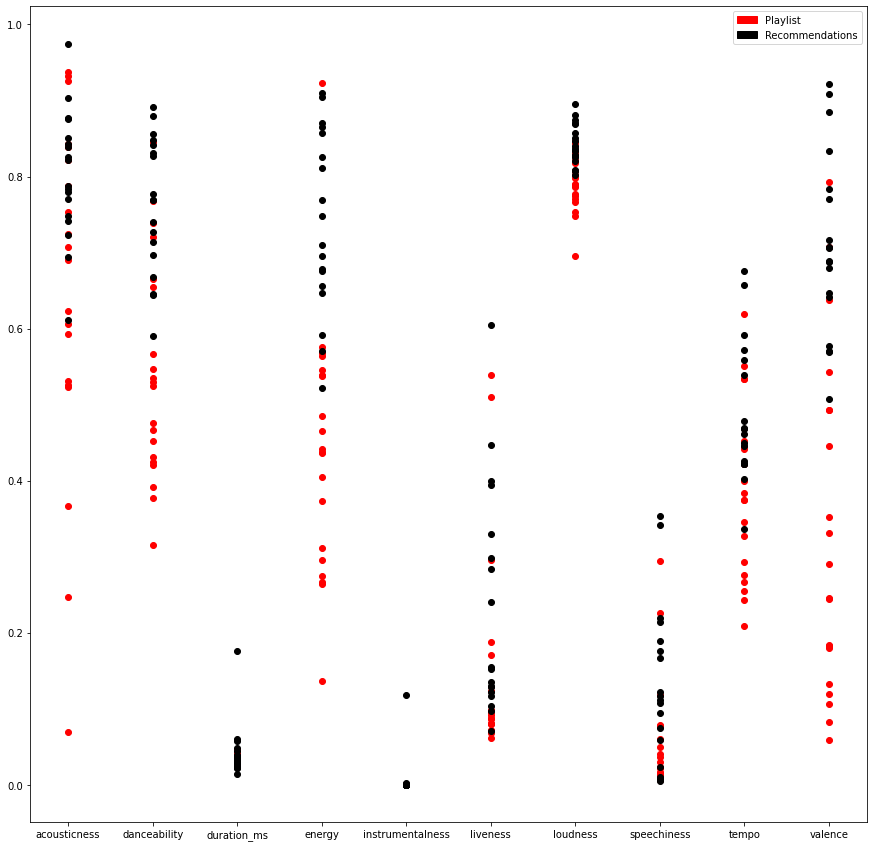

In [ ]:
def display_bar(x, y1, y2):
    
    plt.figure(figsize=(15, 15))
    for i in range(len(y1)):
        plt.scatter(x, y1[i], color = 'red')

    for i in range(len(y2)):
        plt.scatter(x, y2[i], color = 'black')

    red_patch = mpatches.Patch(color='red', label='Playlist')
    black_patch = mpatches.Patch(color='black', label='Recommendations')
    plt.legend(handles=[red_patch, black_patch]) 
    plt.show()
    
display_bar(audio_features, playlist_features_df[audio_features].values, 
            recommendation_features[audio_features].values)

# Evaluation

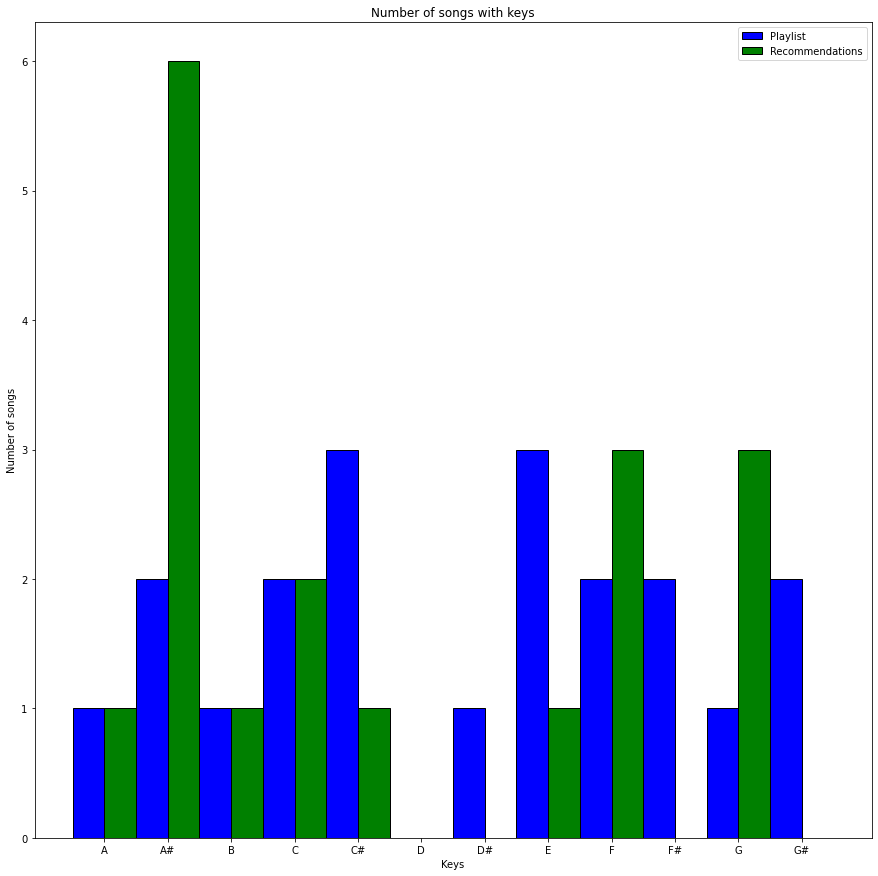

In [ ]:
y = playlist_features_df[keys]
y = y.sum(axis = 0)


y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(15, 15))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Playlist')
    
y = recommendation_features[keys]
y = y.sum(axis = 0)
y = y.values
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Recommendations')
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with keys")

plt.xticks(indices + width/2,keys)
plt.legend()
plt.show()

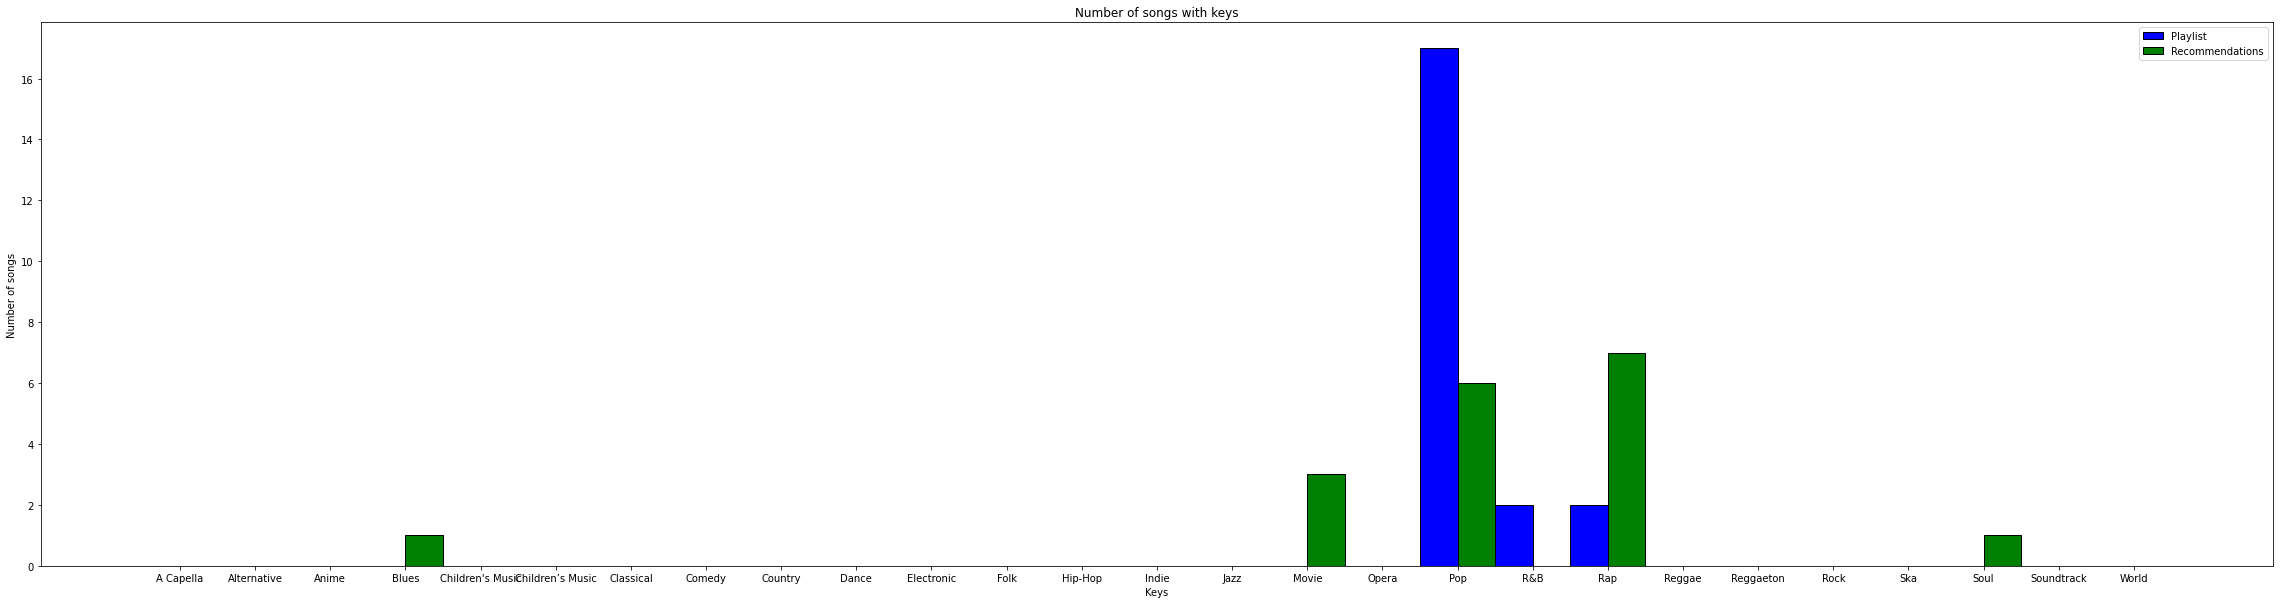

In [ ]:
y = playlist_features_df[genres]
y = y.sum(axis = 0)


y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(40, 10))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Playlist')
    
y = recommendation_features[genres]
y = y.sum(axis = 0)
y = y.values
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Recommendations')
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with keys")

plt.xticks(indices + width/2,genres)
plt.legend()

plt.show()

## Spotify Recommendations Evaluation

In [ ]:
Toprical_house_URL = "https://open.spotify.com/playlist/0b4bDjxAE6MlOswU0JVIXX?si=e96f34c0d26c40df"
Heartbreak_playlist_URL = "https://open.spotify.com/playlist/78HhelFFSkYy4CEXsaf4dA?si=0003f26ed6814981"

# playlist_dataframe = getPlaylistDataFrame(URL)
Tropical_house_playlist_df = getPlaylistDataFrame(Toprical_house_URL)
Heartbreak_playlist_df = getPlaylistDataFrame(Heartbreak_playlist_URL)

In [ ]:
Tropical_house_playlist_df

,id,title,first_artist,all_artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre
0,4bAmAVdks2Y84VNVVLXFwN,Show Me Love - EDX Remix / Radio Edit,Sam Feldt,"[Sam Feldt, Kimberly Anne, EDX]",0.308000,0.836,180336,0.665,0.000925,0.0714,-5.779,0.0745,120.997,0.677,0,"[dance pop, edm, electro house, pop, pop dance..."
1,27NV2KxoQ8WuLMqlTDI61F,Often - Kygo Remix,The Weeknd,"[The Weeknd, Kygo]",0.123000,0.523,234400,0.491,0.000000,0.3310,-9.876,0.0491,80.156,0.408,7,"[canadian contemporary r&b, canadian pop, pop]"
2,2WrlysXGhULyfprVfW20UT,High Hopes,Lucas Estrada,"[Lucas Estrada, Twan Ray, Solar State]",0.631000,0.677,127021,0.537,0.000413,0.1360,-6.287,0.0336,93.996,0.299,7,"[deep house, deep pop edm, deep tropical house..."
3,6RBsFW2PBiJtCYZmNpia5G,Regulate - Le Boeuf Remix,Warren G,"[Warren G, Nate Dogg, Le Boeuf]",0.070200,0.850,218571,0.729,0.049800,0.0542,-4.088,0.0496,111.990,0.731,6,"[g funk, gangster rap, hardcore hip hop, hip h..."
4,4r8hRPbidDIoDPphxi78aY,I Got U,Duke Dumont,"[Duke Dumont, Jax Jones]",0.003640,0.653,285596,0.756,0.006510,0.0890,-7.794,0.0366,120.820,0.420,0,"[destroy techno, edm, electro house, house, po..."
5,7MCgEv2ovQuxfijz2WZ4kH,Feels Like Home - Radio Edit,The Him,"[The Him, Son Mieux]",0.026500,0.650,184918,0.827,0.000059,0.1660,-3.792,0.0926,122.057,0.498,8,"[big room, deep house, deep tropical house, ed..."
6,3oNaNQlmABqzAMQTmyAjaP,First Time (feat. iann dior) - Sam Feldt Remix,ILLENIUM,"[ILLENIUM, Sam Feldt, iann dior]",0.087800,0.697,169728,0.781,0.000000,0.1020,-5.450,0.0503,91.942,0.516,9,"[edm, melodic dubstep, pop, pop dance, tropica..."
7,4ob71GMH7PAokRzPhejagR,Awa Ni,The Knocks,"[The Knocks, Kah-Lo]",0.035800,0.667,219777,0.818,0.000117,0.3290,-6.167,0.1310,119.005,0.430,1,"[alternative dance, edm, indie poptimism, nu d..."
8,4MmESCOyomLv2BmcHkVAQY,Forever And A Day - LVNDSCAPE Remix,Bolier,"[Bolier, Natalie Peris, LVNDSCAPE]",0.028300,0.678,235036,0.874,0.057700,0.1040,-6.768,0.0346,118.429,0.477,6,"[deep tropical house, electro house, tropical ..."
9,6n0OQD5aGspHuwFPJ2ePGC,Sun Don't Shine,Klangkarussell,"[Klangkarussell, Jaymes Young]",0.191000,0.456,237695,0.563,0.001090,0.0978,-8.627,0.0644,119.940,0.213,5,"[austrian pop, deep house, new french touch, t..."


In [ ]:
Heartbreak_playlist_df

,id,title,first_artist,all_artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre
0,0u2P5u6lvoDfwTYjAADbn4,lovely (with Khalid),Billie Eilish,"[Billie Eilish, Khalid]",0.9340,0.351,200186,0.296,0.000000,0.0950,-10.109,0.0333,115.284,0.1200,4,"[art pop, electropop, pop]"
1,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,Lewis Capaldi,[Lewis Capaldi],0.7510,0.501,182161,0.405,0.000000,0.1050,-5.679,0.0319,109.891,0.4460,1,"[pop, uk pop]"
2,7vRriwrloYVaoAe3a9wJHe,"i hate u, i love u (feat. olivia o'brien)",Garrett Nash,"[Garrett Nash, Olivia O'Brien]",0.6870,0.492,251034,0.275,0.000000,0.1010,-13.400,0.3000,92.600,0.1800,6,"[electropop, pop, pop rap]"
3,7795WJLVKJoAyVoOtCWqXN,I'm Not The Only One,Sam Smith,[Sam Smith],0.5290,0.677,239317,0.485,0.000020,0.0766,-5.795,0.0361,82.001,0.4930,5,"[dance pop, pop, uk pop]"
4,3pzjHKrQSvXGHQ98dx18HI,What Do You Mean?,Justin Bieber,[Justin Bieber],0.5900,0.845,205680,0.567,0.001420,0.0811,-8.118,0.0956,125.020,0.7930,5,"[canadian pop, pop]"
5,1ZMiCix7XSAbfAJlEZWMCp,Falling,Harry Styles,[Harry Styles],0.8390,0.567,240133,0.267,0.000001,0.0890,-6.502,0.0299,110.011,0.0592,4,[pop]
6,26z6V1SijQq6J3gPIu1H7t,Lost Without You,Freya Ridings,[Freya Ridings],0.9280,0.409,225076,0.137,0.000000,0.0706,-9.169,0.0446,162.080,0.1060,6,[uk pop]
7,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,Post Malone,[Post Malone],0.0689,0.556,223347,0.538,0.000000,0.1960,-5.408,0.0382,143.950,0.2910,8,"[dfw rap, melodic rap, rap]"
8,7lPN2DXiMsVn7XUKtOW1CS,drivers license,Olivia Rodrigo,[Olivia Rodrigo],0.7210,0.585,242014,0.436,0.000013,0.1050,-8.761,0.0601,143.874,0.1320,10,[pop]
9,13HVjjWUZFaWilh2QUJKsP,Let It Go,James Bay,[James Bay],0.8180,0.546,260533,0.311,0.000017,0.1070,-10.396,0.0288,147.464,0.2460,1,"[modern rock, neo mellow, pop, pop rock]"


In [ ]:
Tropical_House_features_df = create_playlist_df(Tropical_house_playlist_df)
Heartbreak_features_df = create_playlist_df(Heartbreak_playlist_df)

# storing the playlist_features columns and columns from complete_features_df so that they can
# be used later to extract specific features
Tropical_House_features_columns = Tropical_House_features_df.columns.values
Heartbreak_features_columns = Heartbreak_features_df.columns.values

# going to apply the same scaling we applied on the complete_playlist dataframe on the playlist_features_df
scaled_features = scalar.transform(Tropical_House_features_df[Tropical_House_features_columns[1:]])
scaled_features = pd.DataFrame(scaled_features, columns = Tropical_House_features_columns[1:])

scaled_features['id'] = Tropical_House_features_df['id']
Tropical_House_features_df = scaled_features.copy()

scaled_features = scalar.transform(Heartbreak_features_df[Heartbreak_features_columns[1:]])
scaled_features = pd.DataFrame(scaled_features, columns = Heartbreak_features_columns[1:])

scaled_features['id'] = Heartbreak_features_df['id']
Heartbreak_features_df = scaled_features.copy()

In [ ]:
Tropical_House_features_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,id
0,0.309237,0.835855,0.029787,0.665659,0.000926,0.062333,0.830555,0.055356,0.426389,0.677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4bAmAVdks2Y84VNVVLXFwN
1,0.123494,0.500054,0.039551,0.491481,0.000000,0.324468,0.757656,0.028472,0.234218,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27NV2KxoQ8WuLMqlTDI61F
2,0.633534,0.665272,0.020160,0.537528,0.000413,0.127564,0.821516,0.012066,0.299340,0.299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2WrlysXGhULyfprVfW20UT
3,0.070482,0.850874,0.036692,0.729724,0.049850,0.044965,0.860643,0.029001,0.384008,0.731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6RBsFW2PBiJtCYZmNpia5G
4,0.003655,0.639524,0.048796,0.756752,0.006517,0.080105,0.794701,0.015241,0.425557,0.420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4r8hRPbidDIoDPphxi78aY
5,0.026606,0.636305,0.030615,0.827824,0.000059,0.157856,0.865910,0.074513,0.431377,0.498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7MCgEv2ovQuxfijz2WZ4kH
6,0.088153,0.686729,0.027872,0.781777,0.000000,0.093232,0.836409,0.029742,0.289676,0.516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3oNaNQlmABqzAMQTmyAjaP
7,0.035944,0.654544,0.036910,0.818815,0.000117,0.322448,0.823651,0.115157,0.417016,0.430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4ob71GMH7PAokRzPhejagR
8,0.028414,0.666345,0.039666,0.874872,0.057758,0.095251,0.812957,0.013124,0.414306,0.477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4MmESCOyomLv2BmcHkVAQY
9,0.191767,0.428173,0.040146,0.563555,0.001091,0.088991,0.779879,0.044666,0.421416,0.213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6n0OQD5aGspHuwFPJ2ePGC


In [ ]:
Heartbreak_features_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,id
0,0.937751,0.315524,0.033372,0.296282,0.000000,0.086163,0.753510,0.011749,0.399508,0.1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0u2P5u6lvoDfwTYjAADbn4
1,0.754016,0.476451,0.030117,0.405393,0.000000,0.096261,0.832334,0.010267,0.374132,0.4460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7qEHsqek33rTcFNT9PFqLf
2,0.689759,0.466795,0.042555,0.275261,0.000000,0.092222,0.694952,0.294030,0.292772,0.1800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7vRriwrloYVaoAe3a9wJHe
3,0.531124,0.665272,0.040439,0.485475,0.000020,0.067584,0.830270,0.014712,0.242900,0.4930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7795WJLVKJoAyVoOtCWqXN
4,0.592369,0.845510,0.034364,0.567559,0.001421,0.072127,0.788936,0.077688,0.445319,0.7930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3pzjHKrQSvXGHQ98dx18HI
5,0.842369,0.547259,0.040586,0.267252,0.000001,0.080105,0.817690,0.008150,0.374697,0.0592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1ZMiCix7XSAbfAJlEZWMCp
6,0.931727,0.377749,0.037867,0.137120,0.000000,0.061525,0.770235,0.023709,0.619699,0.1060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26z6V1SijQq6J3gPIu1H7t
7,0.069177,0.535458,0.037555,0.538529,0.000000,0.188149,0.837156,0.016935,0.534391,0.2910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75ZvA4QfFiZvzhj2xkaWAh
8,0.723896,0.566570,0.040926,0.436425,0.000013,0.096261,0.777495,0.040114,0.534034,0.1320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7lPN2DXiMsVn7XUKtOW1CS
9,0.821285,0.524729,0.044270,0.311297,0.000017,0.098280,0.748403,0.006986,0.550926,0.2460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13HVjjWUZFaWilh2QUJKsP


In [ ]:
# generate reccommended songs for both playlists using the cosine similarity model
def return_recommendation_features(playlist_df):
    result = generate_recommend_playlist(complete_feature_dataframe, playlist_df, tracks)
    result = result.drop('sim', axis = 1)
    result = result.drop_duplicates()
    return complete_feature_dataframe.iloc[result.index]

Topical_House_Recommended_song_features = return_recommendation_features(Tropical_House_features_df)
Heartbreak_Recommended_song_features = return_recommendation_features(Heartbreak_features_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
Topical_House_Recommended_song_features

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,track_id
110870,0.210843,0.738226,0.038668,0.944944,0.000001,0.326487,0.862938,0.118332,0.703977,0.951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0Gx4VrHzS7pZOEAGrmXXBH
120780,0.306225,0.873404,0.037962,0.931931,0.002753,0.224501,0.868490,0.029742,0.445366,0.767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38I8OemgIPYHdP5uBNY8BO
119361,0.196787,0.759682,0.025451,0.938938,0.000688,0.479971,0.885020,0.027413,0.507863,0.965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4DLH2fr8pWX1iksMrk47Kw
122222,0.115462,0.923828,0.053211,0.885884,0.000000,0.218442,0.864985,0.046994,0.421496,0.819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6oCZE1hdCEac5NnqMUotjh
119944,0.174699,0.796159,0.029315,0.935935,0.000000,0.368897,0.890091,0.315199,0.525014,0.842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0C6TGlpffTuUdJfjB0U9mI
118258,0.135542,0.818689,0.040454,0.937937,0.000128,0.343653,0.847796,0.034822,0.473424,0.906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42nSaPdT6g3ZIMHmKLlP2p
112993,0.171687,0.919537,0.047046,0.813810,0.000000,0.115446,0.869202,0.149026,0.516224,0.962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4LwOrnuxJwR7C5Sw4liY4Z
122040,0.266064,0.765047,0.033536,0.971971,0.000021,0.326487,0.855252,0.279213,0.666052,0.710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1hTDkP80nFhCeyawRpUyAk
119059,0.226908,0.828345,0.033940,0.915914,0.000013,0.238638,0.876355,0.088696,0.416536,0.779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7A0apkTSTvMbSI7yplcmlh
150191,0.201807,0.775775,0.036083,0.882881,0.000011,0.141700,0.855661,0.118332,0.652049,0.926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0Ed7MeXx64f6OcIuoTRCg1


In [ ]:
Heartbreak_Recommended_song_features

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,track_id
113864,0.740964,0.776848,0.039599,0.810807,0.000000,0.135642,0.856853,0.353302,0.675547,0.908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365wwIjijQdlRJEjUWTidq
120522,0.779116,0.856239,0.025337,0.825822,0.000412,0.154827,0.827263,0.075148,0.421529,0.680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4yCuBvbBvoJ9eVE7QB2Rkg
117876,0.770080,0.841219,0.045062,0.678672,0.000000,0.394141,0.850394,0.176545,0.426512,0.717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2jBQmxZpQxF8jJfEdjJ9Qv
151981,0.822289,0.667418,0.031417,0.646639,0.000000,0.330526,0.873917,0.005610,0.445394,0.706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2lQkPuLLQ3gs2tXj7VAYDH
112892,0.876506,0.713550,0.035506,0.675669,0.118118,0.298214,0.833562,0.058531,0.421755,0.507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6m6R6O2BOZDCNymhJ45spI
118190,0.875502,0.644888,0.057828,0.748744,0.000006,0.605182,0.820875,0.189246,0.571686,0.571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3F3N97ZRJJf42YPpwy4iJZ
196405,0.843373,0.847656,0.021687,0.856854,0.000632,0.129583,0.846480,0.023815,0.469523,0.783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3S16UM2l4UI2pkyaGb0Vsm
110978,0.838353,0.643815,0.031415,0.591583,0.000000,0.240657,0.871017,0.007938,0.478355,0.687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4ggabbjjuHrG06SsYnqvEs
151781,0.611446,0.891643,0.037676,0.864862,0.000021,0.097271,0.895838,0.110923,0.402689,0.770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6CWMm2mJOrKyDH4W1X5d06
54494,0.903614,0.831563,0.175580,0.909908,0.000000,0.400200,0.825768,0.121507,0.335943,0.642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4dVhZ2EXWZwXrVAbLwRWM7


In [ ]:
Tropical_house_recommended_track_urls = ["https://open.spotify.com/track/1waX1HHzae5HDdOVEelbIL?si=7a1dd048f4744968",
                                          "https://open.spotify.com/track/7jFuj6FV32pOgf0WU9t6bM?si=d7c9d9ea577f4903",
                                          "https://open.spotify.com/track/2vhnIXHAGLTOelfXyT0q5G?si=5ac15761e71542f4",
                                          "https://open.spotify.com/track/68Har8rtDioPCYXry1iSSY?si=dc53caf631704f55",
                                          "https://open.spotify.com/track/5ug9gNueuS7ReifuwGLdml?si=cb81354b6cea4489",
                                          "https://open.spotify.com/track/0PZDr6dxJhgBjmBZ3w81cr?si=dd06f451ec334f7c",
                                          "https://open.spotify.com/track/2YDKW31FLSlyW6az564oRS?si=2df2257e728a4bae",
                                          "https://open.spotify.com/track/6UqRGwjwYL0stXbaodTxwo?si=96ca6de3514c4338",
                                          "https://open.spotify.com/track/4qB9e24mvDa5rG93OnmiC8?si=82fe9ae41c894c32",
                                          "https://open.spotify.com/track/64dkTKKNLwbjBuU4xnS2ei?si=b347ab1fc1ec442a"]


Heartbreak_recommended_track_urls = ["https://open.spotify.com/track/5uCax9HTNlzGybIStD3vDh?si=39fda1c72d0b49d1",
                                      "https://open.spotify.com/track/2RttW7RAu5nOAfq6YFvApB?si=070f55a0a93a4d38",
                                      "https://open.spotify.com/track/1mXVgsBdtIVeCLJnSnmtdV?si=cb6eba5ffca44ab5",
                                      "https://open.spotify.com/track/21TcDbGosp7w9YhTjOszgA?si=d164e8704107437c",
                                      "https://open.spotify.com/track/0VhgEqMTNZwYL1ARDLLNCX?si=090ccfd75a8f45cb",
                                      "https://open.spotify.com/track/2afCBiru10AFckfOa49wIa?si=514f6b59e30c4145",
                                      "https://open.spotify.com/track/5vjLSffimiIP26QG5WcN2K?si=3873325611ce4925",
                                      "https://open.spotify.com/track/69vToJ9BMbbLlFZo7k7A7B?si=a88299cc02f84fea",
                                      "https://open.spotify.com/track/3BYyBzKGPOCHeginhe0F77?si=a31a51c2264a4133",
                                      "https://open.spotify.com/track/2BOqDYLOJBiMOXShCV1neZ?si=3753623ca7904b01"]

In [ ]:
def get_recommendations_df(urls):
    songs_info = sp.tracks(urls)

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_genres = []

    # extracting the ids, titles, artists, and first artists, genres from the paylist and appending
    # the values one by one into the lists
    for track in songs_info['tracks']:
        playlist_tracks_id.append(track['id'])
        playlist_tracks_titles.append(track['name'])

        artist_list = []
        for artist in track['artists']:
            artist_list.append(artist['name'])
        playlist_tracks_artists.append(artist_list)
        playlist_tracks_first_artists.append(artist_list[0])

        artist_uri = track["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)
        artist_genres = artist_info["genres"]

        genre_list = []
        for genre in artist_genres:
            genre_list.append(genre)

        playlist_tracks_genres.append(genre_list)


    # extracting the audio features from spotify by using playlist_tracks_ids
    features = sp.audio_features(playlist_tracks_id)

    # creating features dataframe from features list
    features_df = pd.DataFrame(data=features, columns=features[0].keys())

    # defining the title, first_artist, all artistsm genre for feature_df by using the already created lists
    features_df['title'] = playlist_tracks_titles
    features_df['first_artist'] = playlist_tracks_first_artists
    features_df['all_artists'] = playlist_tracks_artists
    features_df['genre'] = playlist_tracks_genres


    # extracting the required columns
    features_df = features_df[['id', 'title', 'first_artist', 'all_artists',
                                'acousticness', 'danceability', 'duration_ms', 
                               'energy', 'instrumentalness', 'liveness', 
                               'loudness', 'speechiness', 'tempo', 'valence', 'key', 'genre']]
    return features_df


Tropical_house_recommendations_df = get_recommendations_df(Tropical_house_recommended_track_urls)
Heartbreak_recommendations_df = get_recommendations_df(Heartbreak_recommended_track_urls)

In [ ]:
Tropical_house_recommendations_df

,id,title,first_artist,all_artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre
0,1waX1HHzae5HDdOVEelbIL,Safety - On June Remix,Other,"[Other, Brandon Banks, On June]",0.1160,0.561,174000,0.838,0.000000,0.0813,-4.843,0.0399,119.859,0.3630,8,[]
1,7jFuj6FV32pOgf0WU9t6bM,King - Basic Tape Remix,GRADES,"[GRADES, Basic Tape]",0.1200,0.691,268138,0.679,0.016300,0.0730,-6.411,0.0466,116.016,0.2590,1,[uk dance]
2,2vhnIXHAGLTOelfXyT0q5G,Swim - offrami Remix,Cape Cub,"[Cape Cub, offrami]",0.2050,0.752,160631,0.790,0.000002,0.1850,-6.041,0.0406,115.978,0.5920,0,[north east england indie]
3,68Har8rtDioPCYXry1iSSY,Freak - Sam Feldt Remix Edit,R3HAB,"[R3HAB, Quintino, Sam Feldt]",0.4170,0.625,195613,0.733,0.000000,0.2610,-6.776,0.1240,117.959,0.5070,11,"[dance pop, dutch house, edm, electro house, p..."
4,5ug9gNueuS7ReifuwGLdml,Ocean Drive - Michael Calfan Remix,Duke Dumont,"[Duke Dumont, Michael Calfan]",0.0671,0.761,285000,0.686,0.020800,0.0544,-6.821,0.0499,122.980,0.7980,8,"[destroy techno, edm, electro house, house, po..."
5,0PZDr6dxJhgBjmBZ3w81cr,Sunset Lover - Zac Samuel Remix,Petit Biscuit,"[Petit Biscuit, Zac Samuel]",0.6100,0.691,180572,0.642,0.097600,0.1400,-8.272,0.0300,117.993,0.2540,6,"[new french touch, tropical house]"
6,2YDKW31FLSlyW6az564oRS,Ori tali ma - LVNDSCAPE Remix,Sander van Doorn,"[Sander van Doorn, LVNDSCAPE]",0.0148,0.678,261818,0.825,0.318000,0.1100,-5.590,0.0307,110.011,0.0838,3,"[dutch trance, edm, electro house, house, pop ..."
7,6UqRGwjwYL0stXbaodTxwo,Seve - Radio Edit,Tez Cadey,[Tez Cadey],0.4440,0.740,210853,0.831,0.003040,0.0769,-7.321,0.0456,121.034,0.4480,5,"[deep tropical house, new french touch, tropic..."
8,4qB9e24mvDa5rG93OnmiC8,Praying To A God - LUKE Remix,Mr. Probz,"[Mr. Probz, LUKE]",0.1560,0.839,194790,0.621,0.000028,0.1190,-8.010,0.0463,120.009,0.2080,3,"[dutch hip hop, tropical house]"
9,64dkTKKNLwbjBuU4xnS2ei,Games Continued (feat. Marie Plassard) - Radio...,Bakermat,"[Bakermat, GoldFish, Marie Plassard]",0.0357,0.656,203707,0.618,0.000325,0.3150,-6.608,0.0284,127.034,0.2290,9,"[deep euro house, minimal tech house, pop danc..."


In [ ]:
Heartbreak_recommendations_df

,id,title,first_artist,all_artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre
0,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,[James Arthur],0.6950,0.358,211467,0.557,0.000000,0.0902,-7.398,0.0590,85.043,0.494,10,"[pop, talent show, uk pop]"
1,2RttW7RAu5nOAfq6YFvApB,Happier,Ed Sheeran,[Ed Sheeran],0.5360,0.522,207520,0.385,0.000000,0.1350,-7.355,0.0288,89.792,0.236,0,"[pop, uk pop]"
2,1mXVgsBdtIVeCLJnSnmtdV,Too Good At Goodbyes,Sam Smith,[Sam Smith],0.6400,0.681,201000,0.372,0.000000,0.1690,-8.237,0.0432,91.873,0.476,5,"[dance pop, pop, uk pop]"
3,21TcDbGosp7w9YhTjOszgA,Imagination,Shawn Mendes,[Shawn Mendes],0.0743,0.640,217773,0.455,0.000000,0.0694,-5.942,0.0247,89.948,0.333,0,"[canadian pop, dance pop, pop, viral pop]"
4,0VhgEqMTNZwYL1ARDLLNCX,Can I Be Him,James Arthur,[James Arthur],0.3080,0.696,246880,0.543,0.000000,0.0939,-6.164,0.0489,107.969,0.479,11,"[pop, talent show, uk pop]"
5,2afCBiru10AFckfOa49wIa,You & I,One Direction,[One Direction],0.2200,0.574,237933,0.329,0.000000,0.0986,-6.829,0.0274,130.993,0.356,1,"[boy band, pop, post-teen pop, talent show]"
6,5vjLSffimiIP26QG5WcN2K,Hold On,Chord Overstreet,[Chord Overstreet],0.4690,0.618,198853,0.443,0.000000,0.0829,-9.681,0.0526,119.949,0.167,2,[acoustic pop]
7,69vToJ9BMbbLlFZo7k7A7B,You Are The Reason,Calum Scott,[Calum Scott],0.9180,0.329,204326,0.235,0.000000,0.1370,-7.699,0.0303,171.006,0.220,10,"[neo mellow, pop]"
8,3BYyBzKGPOCHeginhe0F77,Never Be Alone,Shawn Mendes,[Shawn Mendes],0.5140,0.376,215813,0.466,0.000058,0.0781,-6.927,0.0353,199.835,0.276,10,"[canadian pop, dance pop, pop, viral pop]"
9,2BOqDYLOJBiMOXShCV1neZ,Dancing On My Own,Calum Scott,[Calum Scott],0.8370,0.681,260285,0.174,0.000034,0.0983,-8.745,0.0315,112.672,0.231,1,"[neo mellow, pop]"


In [ ]:
Tropical_house_recommendations_features_df = create_playlist_df(Tropical_house_recommendations_df)
Heartbreak_recommendations_features_df = create_playlist_df(Heartbreak_recommendations_df)

Tropical_house_recommendations_columns = Tropical_house_recommendations_features_df.columns.values
Heartbreak_recommendations_columns = Heartbreak_recommendations_features_df.columns.values


# going to apply the same scaling we applied on the complete_playlist dataframe on the playlist_features_df
scaled_features = scalar.transform(Tropical_house_recommendations_features_df[Tropical_house_recommendations_columns[1:]])
scaled_features = pd.DataFrame(scaled_features, columns = Tropical_house_recommendations_columns[1:])

scaled_features['id'] = Tropical_house_recommendations_features_df['id']
Tropical_house_recommendations_features_df = scaled_features.copy()

scaled_features = scalar.transform(Heartbreak_recommendations_features_df[Heartbreak_recommendations_columns[1:]])
scaled_features = pd.DataFrame(scaled_features, columns = Heartbreak_recommendations_columns[1:])

scaled_features['id'] = Heartbreak_recommendations_features_df['id']
Heartbreak_recommendations_features_df = scaled_features.copy()

In [ ]:
Tropical_house_recommendations_features_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,id
0,0.116466,0.540822,0.028643,0.838836,0.000000,0.072329,0.847209,0.018734,0.421035,0.3630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1waX1HHzae5HDdOVEelbIL
1,0.120482,0.680292,0.045643,0.679673,0.016316,0.063948,0.819309,0.025826,0.402952,0.2590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7jFuj6FV32pOgf0WU9t6bM
2,0.205823,0.745735,0.026229,0.790787,0.000002,0.177042,0.825893,0.019475,0.402773,0.5920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2vhnIXHAGLTOelfXyT0q5G
3,0.418675,0.609484,0.032546,0.733728,0.000000,0.253784,0.812815,0.107748,0.412095,0.5070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68Har8rtDioPCYXry1iSSY
4,0.067369,0.755391,0.048688,0.686680,0.020821,0.045167,0.812014,0.029318,0.435720,0.7980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5ug9gNueuS7ReifuwGLdml
5,0.612450,0.680292,0.029830,0.642635,0.097698,0.131603,0.786196,0.008256,0.412255,0.2540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0PZDr6dxJhgBjmBZ3w81cr
6,0.014859,0.666345,0.044502,0.825822,0.318318,0.101310,0.833918,0.008997,0.374697,0.0838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2YDKW31FLSlyW6az564oRS
7,0.445783,0.732861,0.035298,0.831828,0.003043,0.067886,0.803117,0.024767,0.426564,0.4480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6UqRGwjwYL0stXbaodTxwo
8,0.156627,0.839073,0.032398,0.621614,0.000028,0.110398,0.790858,0.025508,0.421741,0.2080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4qB9e24mvDa5rG93OnmiC8
9,0.035843,0.642742,0.034008,0.618611,0.000325,0.308311,0.815804,0.006562,0.454796,0.2290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64dkTKKNLwbjBuU4xnS2ei


In [ ]:
Heartbreak_recommendations_features_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,A Capella,Alternative,Anime,Blues,Children's Music,Children’s Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,id
0,0.697791,0.323034,0.035409,0.557549,0.000000,0.081316,0.801747,0.038950,0.257213,0.494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5uCax9HTNlzGybIStD3vDh
1,0.538153,0.498981,0.034697,0.385373,0.000000,0.126554,0.802512,0.006986,0.279559,0.236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2RttW7RAu5nOAfq6YFvApB
2,0.642570,0.669563,0.033519,0.372360,0.000000,0.160886,0.786819,0.022227,0.289351,0.476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1mXVgsBdtIVeCLJnSnmtdV
3,0.074598,0.625577,0.036548,0.455444,0.000000,0.060313,0.827654,0.002646,0.280293,0.333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21TcDbGosp7w9YhTjOszgA
4,0.309237,0.685656,0.041804,0.543534,0.000000,0.085052,0.823704,0.028260,0.365088,0.479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0VhgEqMTNZwYL1ARDLLNCX
5,0.220884,0.554769,0.040189,0.329316,0.000000,0.089798,0.811872,0.005504,0.473424,0.356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2afCBiru10AFckfOa49wIa
6,0.470884,0.601974,0.033131,0.443432,0.000000,0.073945,0.761125,0.032176,0.421458,0.167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5vjLSffimiIP26QG5WcN2K
7,0.921687,0.291921,0.034120,0.235220,0.000000,0.128573,0.796392,0.008573,0.661699,0.220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69vToJ9BMbbLlFZo7k7A7B
8,0.516064,0.342345,0.036194,0.466456,0.000058,0.069098,0.810128,0.013865,0.797350,0.276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3BYyBzKGPOCHeginhe0F77
9,0.840361,0.669563,0.044225,0.174157,0.000034,0.089495,0.777780,0.009843,0.387217,0.231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2BOqDYLOJBiMOXShCV1neZ


# Playlist 1: Tropical House

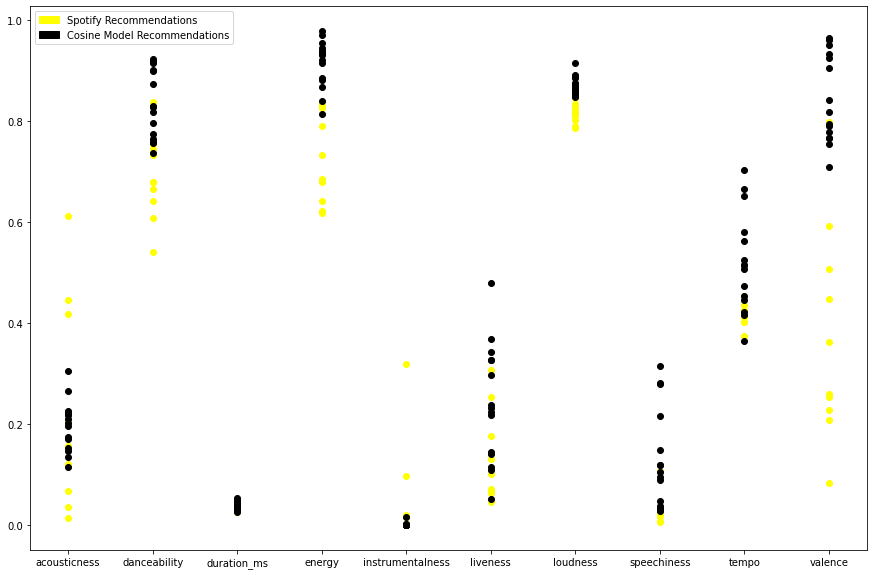

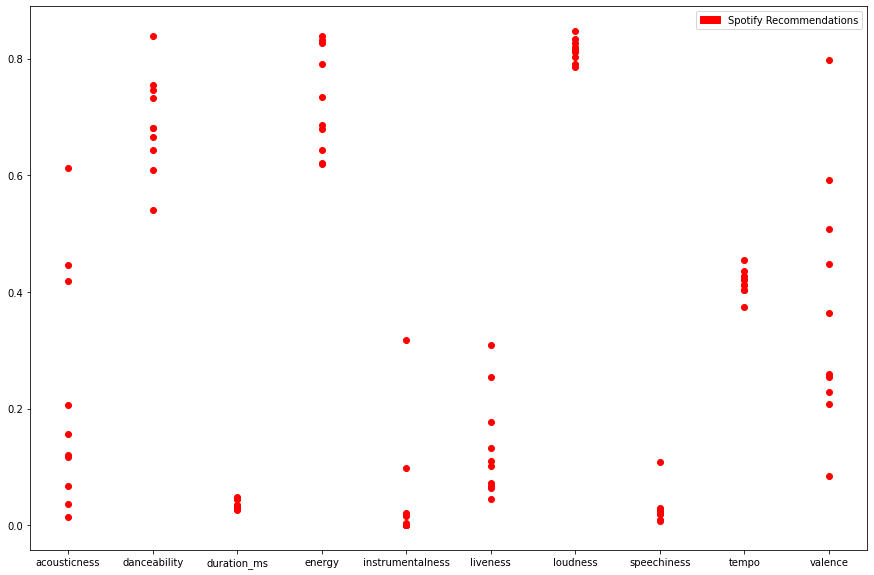

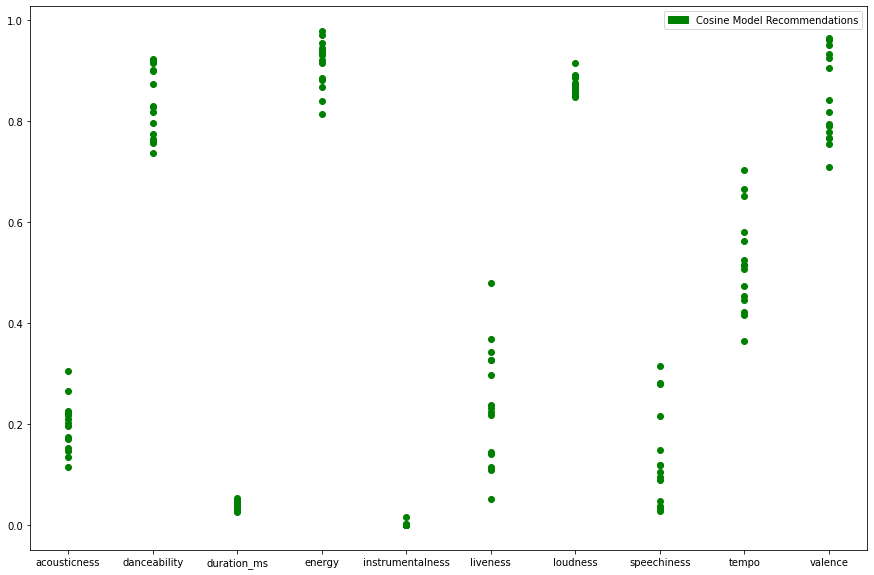

In [ ]:
y = Tropical_house_recommendations_features_df[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Tropical_house_recommendations_features_df.shape[0]):
    plt.scatter(audio_features, y[i], color = 'yellow')
    
y = Topical_House_Recommended_song_features[audio_features]
y = y.values
for i in range(Topical_House_Recommended_song_features.shape[0]):
    plt.scatter(audio_features, y[i], color = 'black')
    
blue_patch = mpatches.Patch(color='yellow', label='Spotify Recommendations')
black_patch = mpatches.Patch(color='black', label='Cosine Model Recommendations')
plt.legend(handles=[blue_patch, black_patch]) 
    
plt.show()

y = Tropical_house_recommendations_features_df[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Tropical_house_recommendations_features_df.shape[0]):
    plt.scatter(audio_features, y[i], color = 'red')

blue_patch = mpatches.Patch(color='red', label='Spotify Recommendations')

plt.legend(handles=[blue_patch]) 
plt.show()

y = Topical_House_Recommended_song_features[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Topical_House_Recommended_song_features.shape[0]):
    plt.scatter(audio_features, y[i], color = 'green')
    

black_patch = mpatches.Patch(color='green', label='Cosine Model Recommendations')
plt.legend(handles=[black_patch]) 
plt.show()

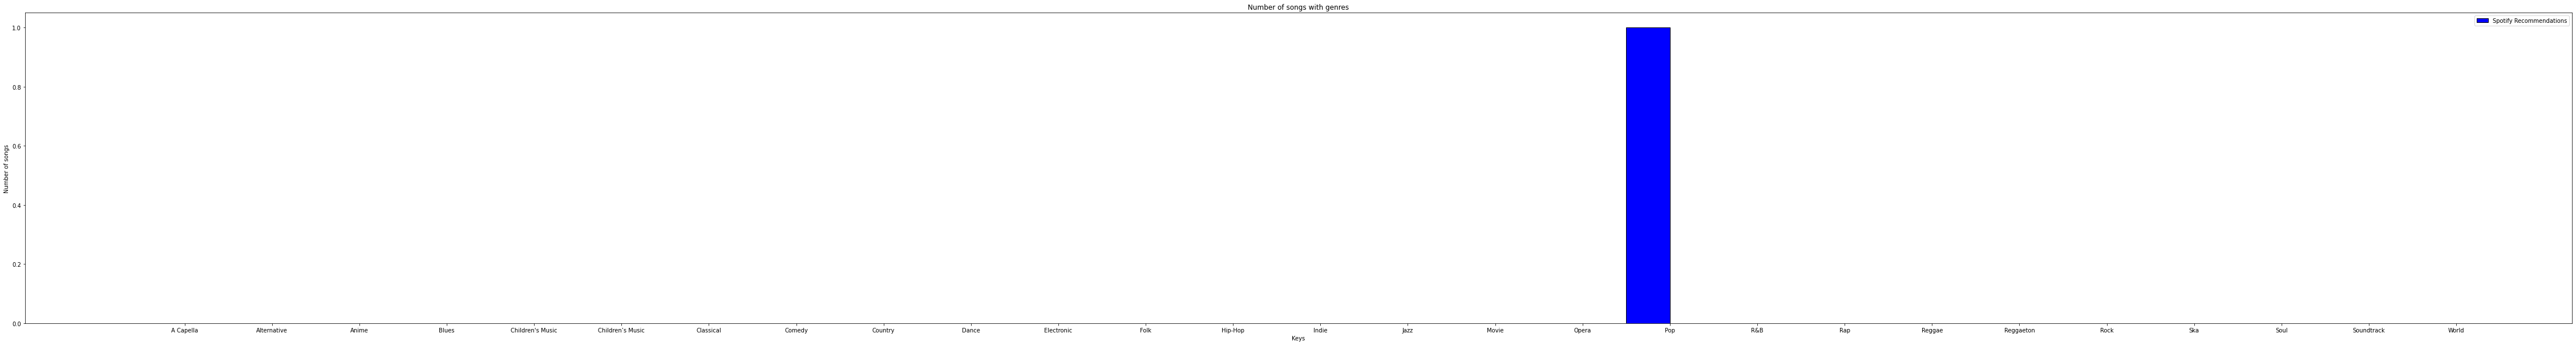

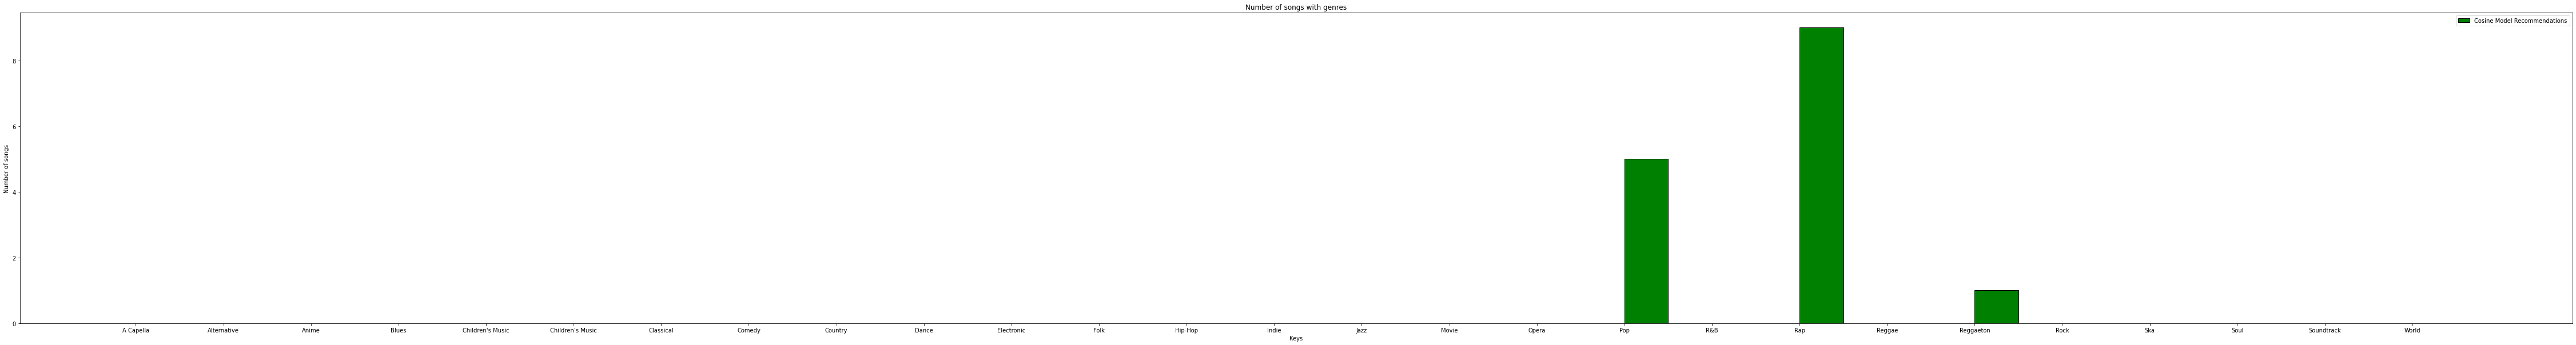

In [ ]:
y = Tropical_house_recommendations_features_df[genres]
y = y.sum(axis = 0)


y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(80, 10))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Spotify Recommendations')
    
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with genres")

plt.xticks(indices + width/2,genres)
plt.legend()


plt.show()

y = Topical_House_Recommended_song_features[genres]
y = y.sum(axis = 0)
y = y.values

indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(80, 10))
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Cosine Model Recommendations')

plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with genres")

plt.xticks(indices + width/2,genres)
plt.legend()


plt.show()

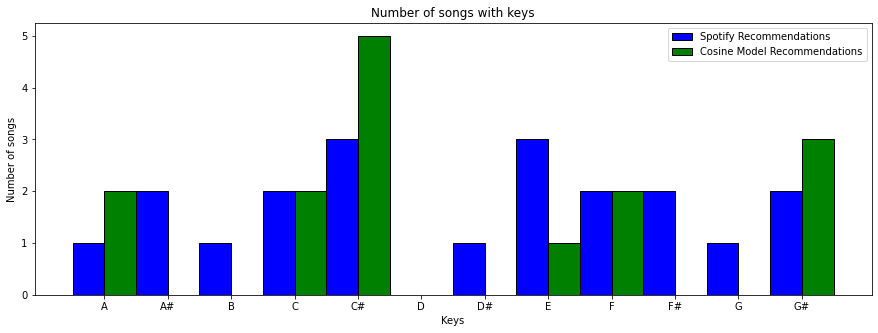

In [ ]:
y = playlist_features_df[keys]
y = y.sum(axis = 0)


y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(15, 5))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Spotify Recommendations')
    
y = Topical_House_Recommended_song_features[keys]
y = y.sum(axis = 0)
y = y.values
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Cosine Model Recommendations')
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with keys")

plt.xticks(indices + width/2,keys)
plt.legend()


plt.show()

Comparing the Spotify Recommendations to the Tropical Playlist Songs

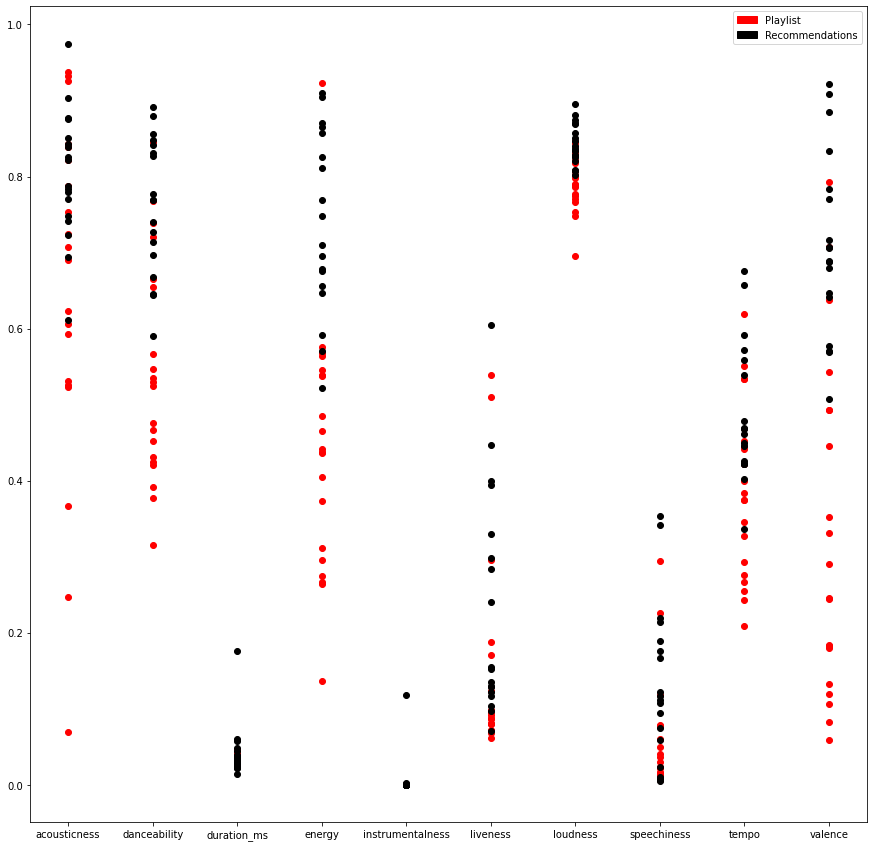

In [ ]:
def display_bar(x, y1, y2):
    
    plt.figure(figsize=(15, 15))
    for i in range(len(y1)):
        plt.scatter(x, y1[i], color = 'red')

    for i in range(len(y2)):
        plt.scatter(x, y2[i], color = 'black')

    red_patch = mpatches.Patch(color='red', label='Playlist')
    black_patch = mpatches.Patch(color='black', label='Recommendations')
    plt.legend(handles=[red_patch, black_patch]) 
    plt.show()
    
display_bar(audio_features, playlist_features_df[audio_features].values, 
            recommendation_features[audio_features].values)

# Playlist 2: Heartbreak list

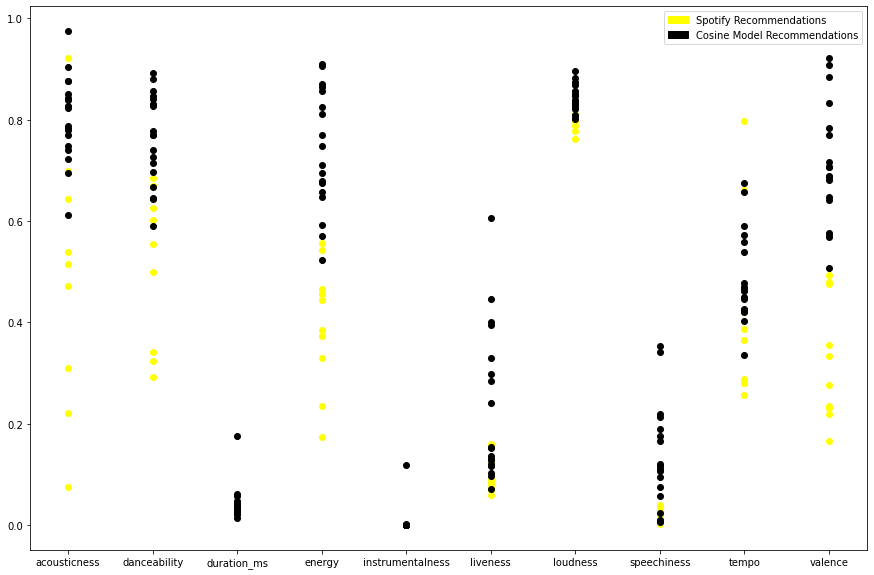

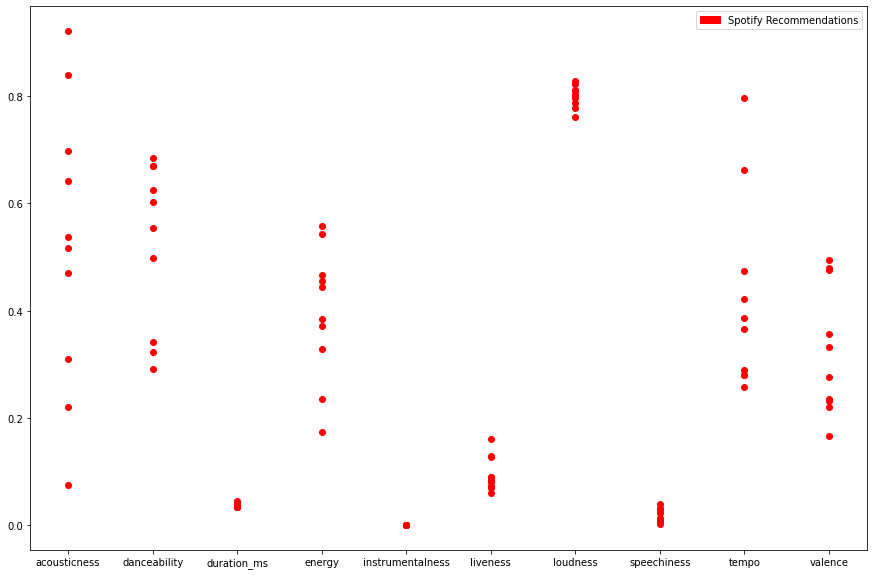

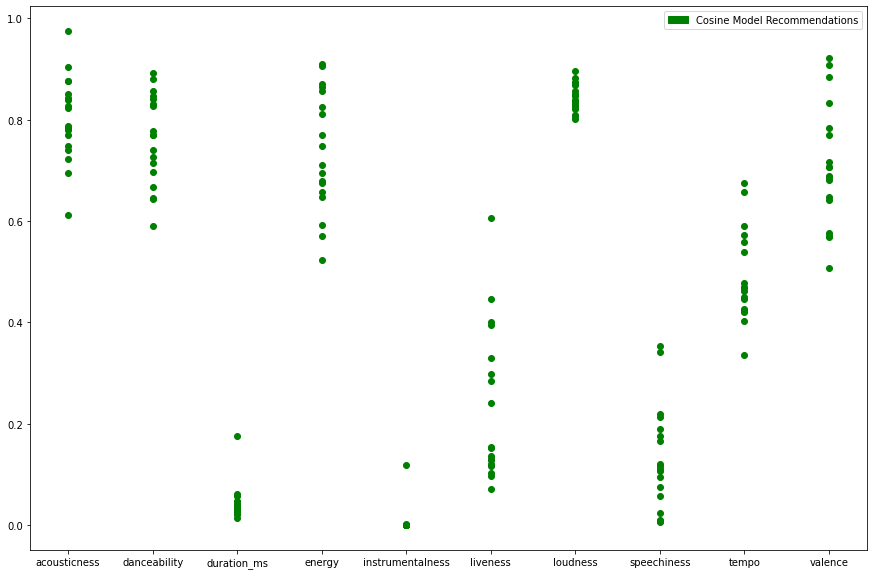

In [ ]:
# Spotify recommendations for the Heartbreak Playlist
y = Heartbreak_recommendations_features_df[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Heartbreak_recommendations_features_df.shape[0]):
    plt.scatter(audio_features, y[i], color = 'yellow')
# Cosine similarity model recommendations for the Heartbreak Playlist
y = Heartbreak_Recommended_song_features[audio_features]
y = y.values
for i in range(Heartbreak_Recommended_song_features.shape[0]):
    plt.scatter(audio_features, y[i], color = 'black')
    
blue_patch = mpatches.Patch(color='yellow', label='Spotify Recommendations')
black_patch = mpatches.Patch(color='black', label='Cosine Model Recommendations')
plt.legend(handles=[blue_patch, black_patch]) 
plt.show()

y = Heartbreak_recommendations_features_df[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Heartbreak_recommendations_features_df.shape[0]):
    plt.scatter(audio_features, y[i], color = 'red')

blue_patch = mpatches.Patch(color='red', label='Spotify Recommendations')

plt.legend(handles=[blue_patch]) 
plt.show()

y = Heartbreak_Recommended_song_features[audio_features]
y = y.values
plt.figure(figsize=(15, 10))
for i in range(Heartbreak_Recommended_song_features.shape[0]):
    plt.scatter(audio_features, y[i], color = 'green')
    

black_patch = mpatches.Patch(color='green', label='Cosine Model Recommendations')
plt.legend(handles=[black_patch]) 
plt.show()

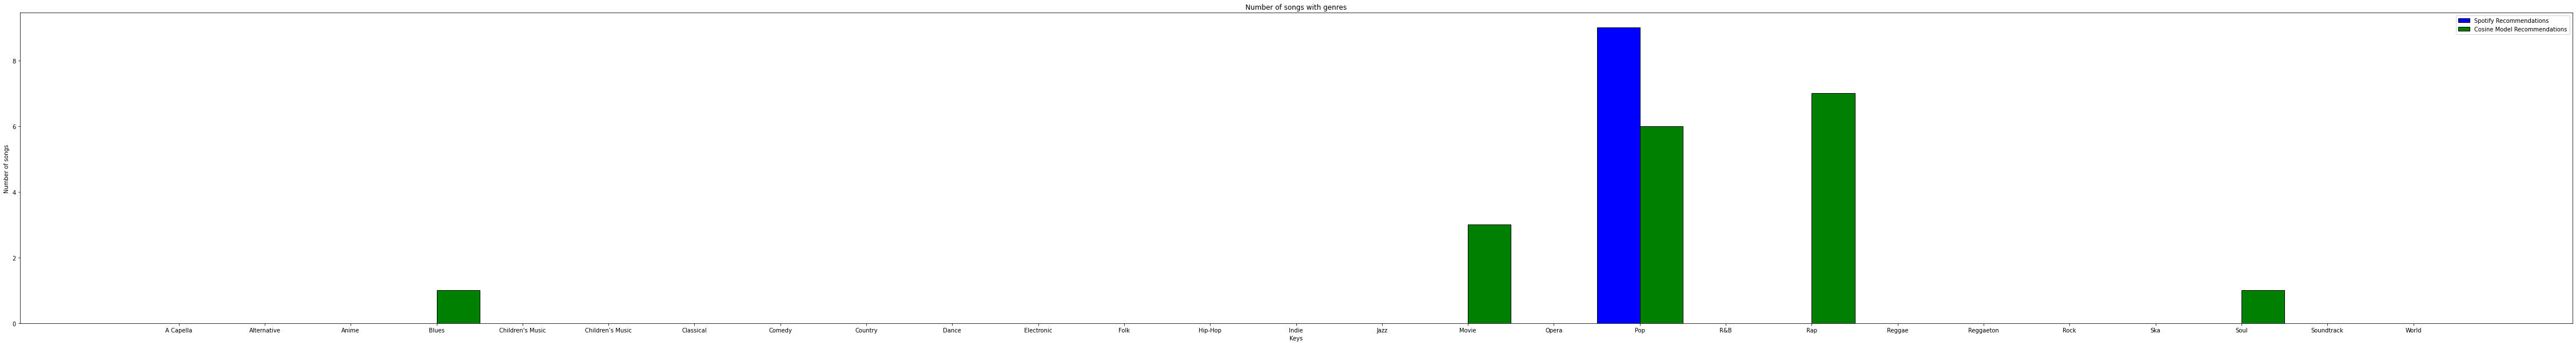

In [ ]:
y = Heartbreak_recommendations_features_df[genres]
y = y.sum(axis = 0)

y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(80, 10))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Spotify Recommendations')
    
y = Heartbreak_Recommended_song_features[genres]
y = y.sum(axis = 0)
y = y.values
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Cosine Model Recommendations')
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with genres")

plt.xticks(indices + width/2,genres)
plt.legend()


plt.show()

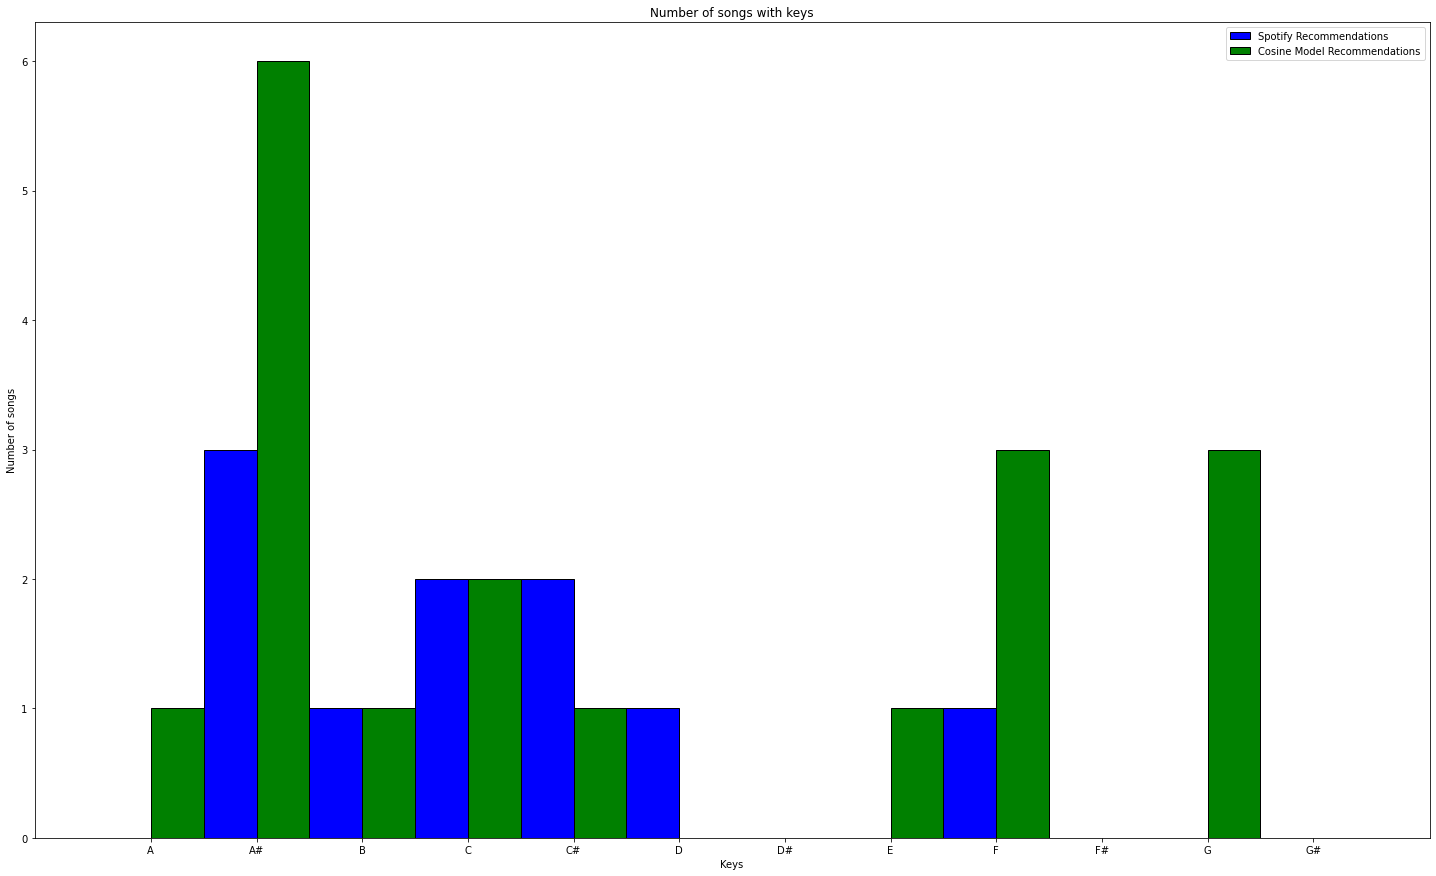

In [ ]:
y = Heartbreak_recommendations_features_df[keys]
y = y.sum(axis = 0)

y = y.values
indices = np.arange(len(y))
width = 0.5

plt.figure(figsize=(25, 15))
plt.bar(indices, y, color = 'b', width = width, edgecolor = 'black', label='Spotify Recommendations')
    
y = Heartbreak_Recommended_song_features[keys]
y = y.sum(axis = 0)
y = y.values
plt.bar(indices + width, y ,color = 'g', width = width, edgecolor = 'black', label = 'Cosine Model Recommendations')
plt.xlabel("Keys")
plt.ylabel("Number of songs")
plt.title("Number of songs with keys")

plt.xticks(indices + width/2,keys)
plt.legend()

plt.show()

In [ ]:
recommendation_features[audio_features]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
113864,0.740964,0.776848,0.039599,0.810807,0.000000,0.135642,0.856853,0.353302,0.675547,0.908
120522,0.779116,0.856239,0.025337,0.825822,0.000412,0.154827,0.827263,0.075148,0.421529,0.680
117876,0.770080,0.841219,0.045062,0.678672,0.000000,0.394141,0.850394,0.176545,0.426512,0.717
151981,0.822289,0.667418,0.031417,0.646639,0.000000,0.330526,0.873917,0.005610,0.445394,0.706
112892,0.876506,0.713550,0.035506,0.675669,0.118118,0.298214,0.833562,0.058531,0.421755,0.507
118190,0.875502,0.644888,0.057828,0.748744,0.000006,0.605182,0.820875,0.189246,0.571686,0.571
196405,0.843373,0.847656,0.021687,0.856854,0.000632,0.129583,0.846480,0.023815,0.469523,0.783
110978,0.838353,0.643815,0.031415,0.591583,0.000000,0.240657,0.871017,0.007938,0.478355,0.687
151781,0.611446,0.891643,0.037676,0.864862,0.000021,0.097271,0.895838,0.110923,0.402689,0.770
54494,0.903614,0.831563,0.175580,0.909908,0.000000,0.400200,0.825768,0.121507,0.335943,0.642


In [ ]:
playlist_features_df[audio_features]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.937751,0.315524,0.033372,0.296282,0.000000,0.086163,0.753510,0.011749,0.399508,0.1200
1,0.754016,0.476451,0.030117,0.405393,0.000000,0.096261,0.832334,0.010267,0.374132,0.4460
2,0.689759,0.466795,0.042555,0.275261,0.000000,0.092222,0.694952,0.294030,0.292772,0.1800
3,0.531124,0.665272,0.040439,0.485475,0.000020,0.067584,0.830270,0.014712,0.242900,0.4930
4,0.592369,0.845510,0.034364,0.567559,0.001421,0.072127,0.788936,0.077688,0.445319,0.7930
5,0.842369,0.547259,0.040586,0.267252,0.000001,0.080105,0.817690,0.008150,0.374697,0.0592
6,0.931727,0.377749,0.037867,0.137120,0.000000,0.061525,0.770235,0.023709,0.619699,0.1060
7,0.069177,0.535458,0.037555,0.538529,0.000000,0.188149,0.837156,0.016935,0.534391,0.2910
8,0.723896,0.566570,0.040926,0.436425,0.000013,0.096261,0.777495,0.040114,0.534034,0.1320
9,0.821285,0.524729,0.044270,0.311297,0.000017,0.098280,0.748403,0.006986,0.550926,0.2460


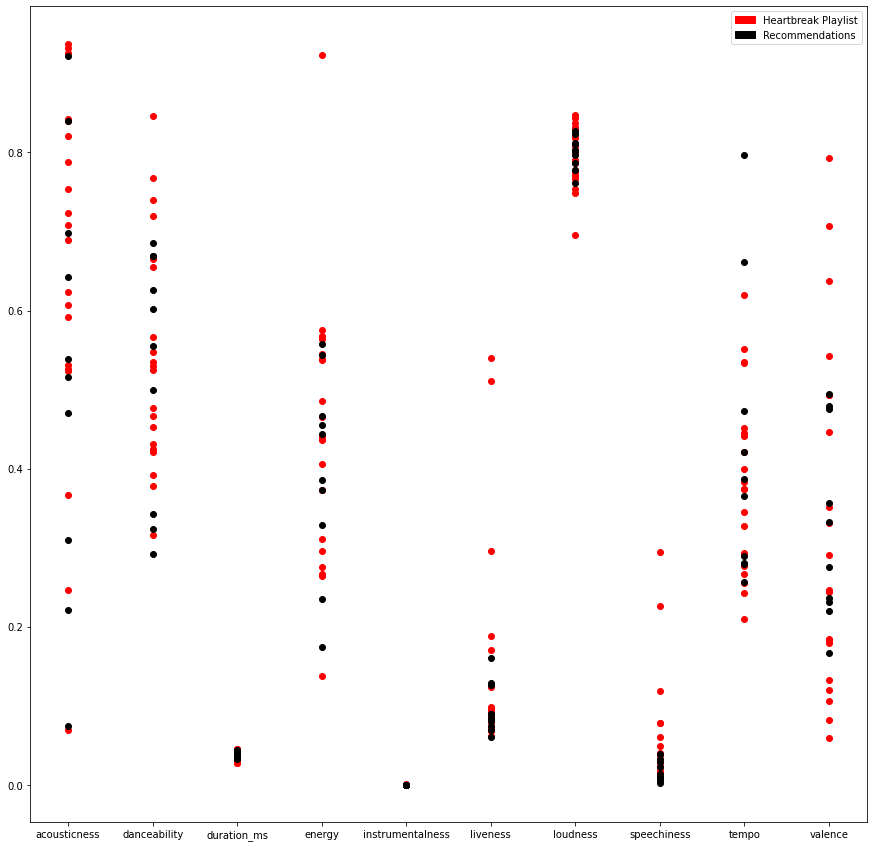

In [ ]:
def display_bar(x, y1, y2):
    
    plt.figure(figsize=(15, 15))
    for i in range(len(y1)):
        plt.scatter(x, y1[i], color = 'red')

    for i in range(len(y2)):
        plt.scatter(x, y2[i], color = 'black')

    red_patch = mpatches.Patch(color='red', label='Heartbreak Playlist')
    black_patch = mpatches.Patch(color='black', label='Recommendations')
    plt.legend(handles=[red_patch, black_patch]) 
    plt.show()
    
display_bar(audio_features, playlist_features_df[audio_features].values, 
            Heartbreak_recommendations_features_df[audio_features].values)

# RESULTS

The comparison of the recommendations from the model and Spotify itself were different in values in this playlist evaluation, the conclusion here is that the Spotify Recommendations were more accurate, or in other words closer to this playlist’s individual songs’ values. Again, there is a lot of limitations here, however it is evident that the Spotify Recommendations were within the range of the playlist’s songs more evenly and closer than the Models in some cases.

The energy levels are better with the Spotify Recommendations, same result with the valance, tempo and danceability, but again these are very hard to measure perfectly. The comparison of the recommendations from the model and Spotify recommendations against each other are evidently not perfectly aligned as well, this was an assumption from the beginning, as Spotify takes into account other things, such as users’ listening preferences, history and more, but the Cosine Similarity Model’s recommendations were quite accurate for such a simple pythonic recommendation engine. 

The actual results of comparing the similarity would be very hard to achieve as the graphs would need to be compared by the distance between the points for each feature of a song for both the Spotify recommendations and the playlist, and the cosine similarity content based filtering model upon which those two abstract numbers of distances between points would have to be taken away from each other in order to know the exact difference in the similarity of the features between this model and Spotify’s own recommendation engine.
